## Implementing DDPM from Scratch

In the DL Deep Dive on Diffusion, I am going to implement **Denoising Diffusion Probabilistic Models** or DDPMs for short from scratch using PyTorch. I will be referring to the paper by [Ho et al](https://arxiv.org/abs/2006.11239) which is among the first papers to introduce Diffusion Models. 


<div style="background-color: rgba(147, 51, 234, 0.1); padding: 10px; border-radius: 5px;">
 Popular models currently using Diffusion Models at its core include <a href="https://openai.com/dall-e-2/">DALL-E 2</a> by OpenAI, <a href="https://github.com/CompVis/latent-diffusion">Latent Diffusion</a> by the University of Heidelberg and <a href="https://imagen.research.google/">ImageGen</a> by Deepmind among many others.
</div>

The idea of Diffusion Models was inspired from non-equilibrium statistical thermodynamics and were first introduced by [Sohl-Dickstein et al., 2015](https://arxiv.org/abs/1503.03585) at Stanford. There exist many variations and approaches to applying Diffusion Models in CV tasks, here we'll be primarily focused on implementing in PyTorch the original TensorFlow codebase by [Ho et al](https://arxiv.org/abs/2006.11239).

## What is a Diffusion Model?

## Investivating the DataSet

We are working with the FGVCAircraft dataset. The dataset contains around 6667 images across 100 different aircraft variants. Each image is labeled with bounding box annotations and multiple levels of aircraft categorization, making it useful for both classification and detection tasks.

The dataset consists of images of aircraft taken from different viewpoints, with annotations specifying:

- The aircraft manufacturer (e.g., Boeing, Airbus)
- The specific model (e.g., Boeing 747-400)
- The aircraft family/variant

However, we are building a generative model and so don't care about specifics about the images. What we care about is making sure all images are of the same size.

In [1]:
import torch
from torchvision import datasets
import matplotlib.pyplot as plt

In [27]:
def show_ds(dataset, num_samples=10, cols=5):
    plt.figure(figsize=(20, 10))
    
    for i, image in enumerate(dataset):
        if i >= num_samples:
            break
            
        plt.subplot(num_samples//cols + 1, cols, i+1)
        plt.imshow(image[0])
    
    plt.tight_layout()
    plt.axis('off')
    plt.show()

100%|██████████| 2753340328/2753340328 [02:48<00:00, 16292867.77it/s]


Extracting ./fgvc-aircraft-2013b.tar.gz to .


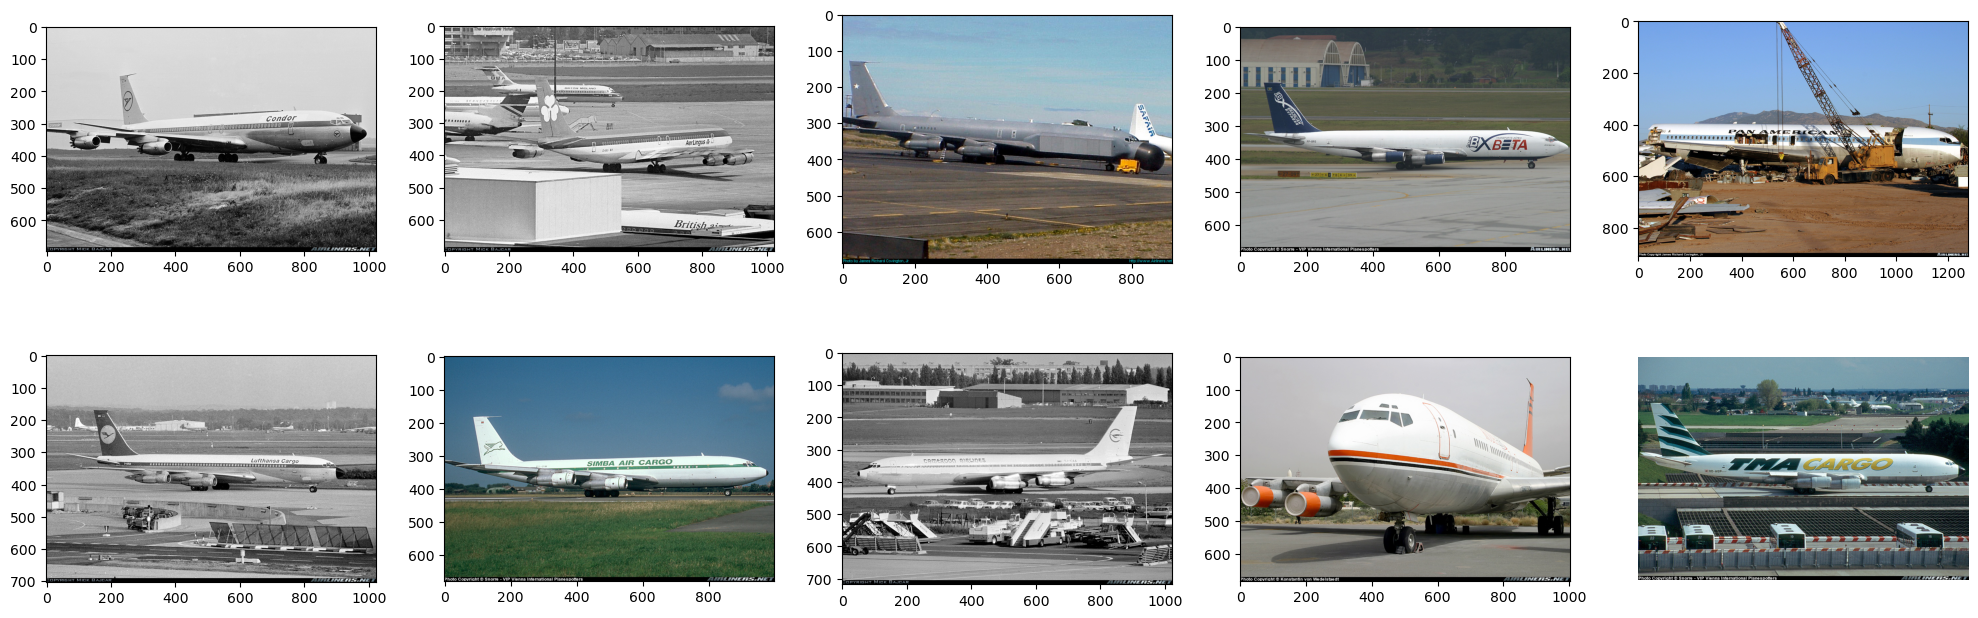

In [29]:
data = datasets.FGVCAircraft(root='.', download=True)
show_ds(data)

In [31]:
print(f"The total samples in the dataset is {len(data)}")

The total samples in the dataset is 6667


## The Diffusion Model: the Forward & Backward Process

### The Forward Process: Noise Scheduler

Diffusion Models like many other generative models such as GANs or VAEs convert noise from a distribution to a data sample. The forward process, in essense, does one thing: add noise to the images.

The forward process is markov process which is denoted by $q$ that gradually adds Gaussian Noise to the images until the result is pure noise.

$$q(\mathbf{x_{1:T}}|\mathbf{x_0}) = \prod_{t=1}^T q(\mathbf{x_{t}}|\mathbf{x_{t-1}})$$

This forward process is iterated using $t$ over $T$ steps. For example, [Ho et al](https://arxiv.org/abs/2006.11239) chose a value of $\mathbf{T}=1000$. To explain this process simply, say you start off with a picture of an aircraft, $\mathbf{x_0}$ at $\mathbf{t=0}$. In the forward process, noise sampled from a Gaussian Distribution is added to $\mathbf{x_0}$ at $\mathbf{t=1}$ to form $\mathbf{x_1}$. Over large number of iterations of this process, noise accumulates leading to the image turning into an [Isotropic Gaussian Distribution](https://math.stackexchange.com/questions/1991961/gaussian-distribution-is-isotropic). Following is a visualisation of the forward process from [Stanford CS236](https://www.youtube.com/watch?v=VsllsC2JMGY)

![Forward Process Visualization](./forward.png)

Further mathematical granularity:

The following equation describes the process of getting to $\mathbf{x_t}$ from $\mathbf{x_{t-1}}$

$$q(\mathbf{x}_t|\mathbf{x}_{t-1}) = \mathcal{N}(\mathbf{x}_t; \sqrt{1-\beta_t}\mathbf{x}_{t-1}, \beta_t\mathbf{I})$$

$\mathcal{N}(\mathbf{x}_t; \sqrt{1-\beta_t}\mathbf{x}_{t-1}, \beta_t\mathbf{I})$ represents the Gaussian Distribution centered at $\sqrt{1-\beta_t}\mathbf{x}_{t-1}$, which is a dimmer version of the original image, with a variance of $\beta_t\mathbf{I}$ where $\mathbf{I}$ is the identity matrix. Simply, $\mathbf{x}_{t}$ is created by adding a dimmer version of the previous image, $\sqrt{1-\beta_t}\mathbf{x}_{t-1}$ with noise scaled by the calculated variance, $\beta_t\mathbf{I}$

### Here is a code snippet demonstrating the Forward Diffusion Process over one step:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.3341979562283721..2.274441116268841].


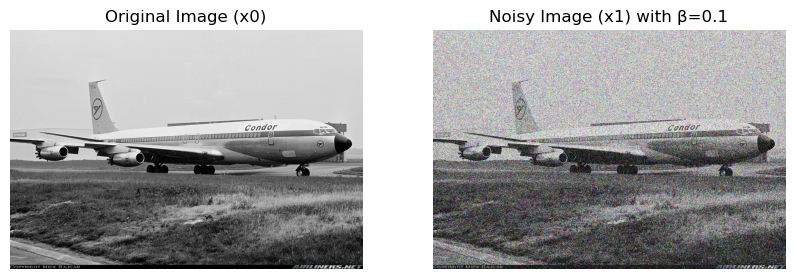

In [63]:
import numpy as np

bt = 0.1
at = 1-bt 
mean_scaling = np.sqrt(at) # Mean Scaling Factor
var_scaling = np.sqrt(bt) # Variance Scaling Factor

x0 = np.array(data[0][0]).astype(np.float32)/255.0 # Normalise x0
noise = np.random.normal(size=x0.shape)
x1 = mean_scaling * x0 + var_scaling * noise

# Plotting
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)  # (rows, columns, index) - indices start at 1, not 0
plt.imshow(x0)
plt.title('Original Image (x0)')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(x1)
plt.title(f'Noisy Image (x1) with β={bt}')
plt.axis('off')

plt.show()